In [1]:
%config Completer.use_jedi=False

In [2]:
import os
import requests
import csv
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pingouin as pg

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin

from scipy.stats import iqr, skew

np.set_printoptions(suppress=True)
mpl.rcParams['image.cmap'] = 'PuOr'

HOUSING_URL = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv'
HOUSING_PATH = os.path.join('housing_dataset')

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    response = requests.get(housing_url, stream=True)
    with open(os.path.join(housing_path, 'housing_data.csv'), 'w') as f:
        writer = csv.writer(f)
        for line in response.iter_lines():
            writer.writerow(line.decode('utf-8').split(','))
    response.close()
    
def load_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing_data.csv')
    return pd.read_csv(csv_path)

In [3]:
#fetch_housing_data()

In [4]:
# load the dataset
housing = load_data()
print(housing.shape)
housing.head()

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Check the basic info about the data.

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We see that there are some values missing in total_bedrooms feature. We will take care of it later. We can simply drop the values or try to impute them, there are also other options using random forest or KNN.

Get basic statistics about the data.

In [6]:
housing.describe().T.join(housing.skew(numeric_only=True).to_frame(name='skew')).round(2)

,count,mean,std,min,25%,50%,75%,max,skew
longitude,20640.0,-119.57,2.00,-124.35,-121.80,-118.49,-118.01,-114.31,-0.30
latitude,20640.0,35.63,2.14,32.54,33.93,34.26,37.71,41.95,0.47
housing_median_age,20640.0,28.64,12.59,1.00,18.00,29.00,37.00,52.00,0.06
total_rooms,20640.0,2635.76,2181.62,2.00,1447.75,2127.00,3148.00,39320.00,4.15
total_bedrooms,20433.0,537.87,421.39,1.00,296.00,435.00,647.00,6445.00,3.46
population,20640.0,1425.48,1132.46,3.00,787.00,1166.00,1725.00,35682.00,4.94
households,20640.0,499.54,382.33,1.00,280.00,409.00,605.00,6082.00,3.41
median_income,20640.0,3.87,1.90,0.50,2.56,3.53,4.74,15.00,1.65
median_house_value,20640.0,206855.82,115395.62,14999.00,119600.00,179700.00,264725.00,500001.00,0.98


Seems like there is a lot skewness in the data, we can get a better look plotting the histograms.

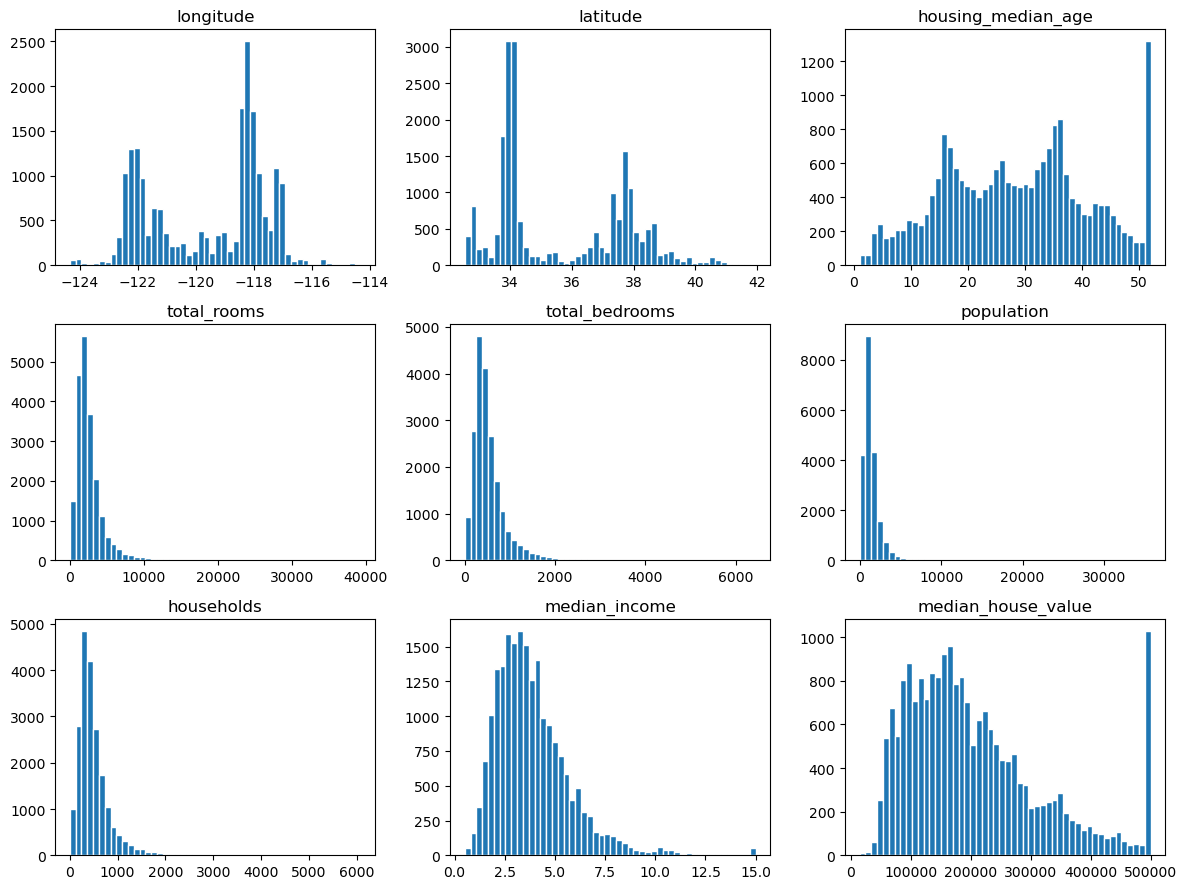

In [7]:
housing.hist(bins=50, ec='white', grid=False, figsize=(12, 9))
plt.tight_layout()
plt.show()

1. We can see that both housing_median_age and median_house_value are capped at their max values, meaning that max values of this feature and target variables contain all the data that was >= than their max values. We also observe similar spike in right-tail in median_income. 
2. Also, median_income does look like it is in 10,000$.
3. All the features have different scales so we should scale them. 
4. A lot of them are heavy-tailed to the right. We can try to apply some transformation later down the road.

We should decide on what to do with capped target variable, as the model we will build could never learn that prices can go beyond the cap. It is also be the case that the differences in other features will not result in the difference in the target variable which can bias the model. We can see from the histogram that there should be around 1000 examples in the dataset, which is around 5% of the data, we can check to be sure, and if this is the case then we will drop those values.

In [8]:
housing['median_house_value'].value_counts(normalize=True).head()

500001.0    0.046754
137500.0    0.005911
162500.0    0.005669
112500.0    0.004990
187500.0    0.004506
Name: median_house_value, dtype: float64

Capped values contribute less than 5% to the dataset, so we are dropping them. We will do so by creating a class, that we can then put into a pipeline, and check at the end if retrieving 500k will make any difference.

The class is called CappedTargetDropper and it is imported from the classes_for_pipeline_py.py file. For more inforamtion or code consult the doc or the code itsefl.

<Axes: >

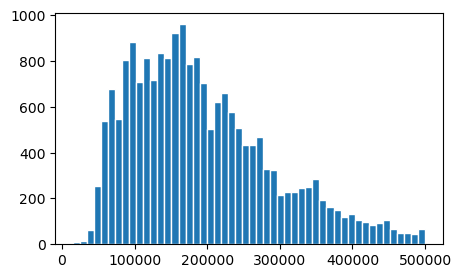

In [9]:
# import CappedTargetDropper
from classes_for_pipeline_py import CappedTargetDropper

# instantiate the class specifying the value to be dropped
capped_target_drop = CappedTargetDropper(capped_val=housing['median_house_value'].max())

# copy the main dataset
housing_w_o_500k = housing.copy()

# drop the capped values
housing_w_o_500k.loc[:, 'median_house_value'] = capped_target_drop.fit_transform(housing['median_house_value'])

# check the distribution
housing_w_o_500k['median_house_value'].hist(ec='white', bins=50, figsize=(5, 3), grid=False)

We can clearly see that the values are no longer there.

We can now split the data into train (80%) and test (20%).

In [10]:
# split the data, we shuffle the data to be sure that the split is not biased
train, test = train_test_split(housing_w_o_500k, test_size=0.2, shuffle=True, random_state=42)
print(f'''train: {train.shape}, test: {test.shape}''')

train: (16512, 10), test: (4128, 10)


We can now copy the training set making sure not to mess something up and start exploring.

In [11]:
# copy the training set
tr = train.copy()

Since we have a longitude and latitude we can plot the region of our data, we can size the points with population and apply color mapping with median_house_value, for better visualization.

<Axes: xlabel='longitude', ylabel='latitude'>

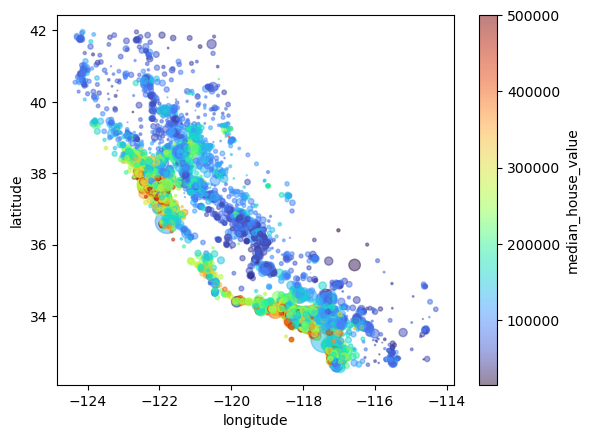

In [12]:
tr.plot(kind='scatter', x='longitude', y='latitude', s=tr['population'] / 100, c='median_house_value', colorbar=True, cmap='turbo', alpha=0.5)

We can clearly see that the closer to the coast we are the higher the median house values, but in Northern California the housing prices are nott too high.

We can take a look at correlations between features and the target variable. But first let's separate numerical features from ocean_proximity.

In [13]:
# separate features
tr_num, tr_cat = tr.drop(columns=['ocean_proximity']), tr.loc[:, 'ocean_proximity']

We should take care of nan values.

In [14]:
tr_num.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms          0
population              0
households              0
median_income           0
median_house_value    786
dtype: int64

There are 162 (~1%) missing values in the total_bedrooms feature, we can thing of bunch of methods to fix it, but we will impute with median value, which is the easiest one.

In [15]:
tr_num.loc[:, 'total_bedrooms'] = SimpleImputer(strategy='median').fit_transform(tr_num['total_bedrooms'].values.reshape(-1, 1))

Later, when we will be constructing the preprocessing pipeline, we will impute on the whole dataset, and store the median value for each feature, to be able to impute if we ever get any nan values in the future data.

In [16]:
corr_matrix = tr_num.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.642407
total_rooms           0.144983
households            0.096007
total_bedrooms        0.076054
housing_median_age    0.061479
population            0.012789
longitude            -0.044505
latitude             -0.149412
Name: median_house_value, dtype: float64

1. We can clearly see that the median_income feature is highly correlated with the target variable. 
2. We see that total_rooms is somehow correlated with target feature, as the number of rooms will definitely affect the overall total area of the house, and the bigger the house, we can assume the higher the price.
3. households and total_bedrooms are mildly correlated with the target variable.

Each observation in the data describes some region in California. Some features are not very informative, for example, total_rooms is not informative and is conterintuitive, its like trying to guess the median house value based on total rooms in the city. We can create new features that should be more informative, but for sure ones that will be intuitive, like for example total rooms per household, or median income per household. Then, we can check how much correlated those features have with the target variable. 

Note: income per household or per population is a little bit trickier, as we have median income per district, so we should think what exactly does it mean. Mean is close to the median most of the times, we assume that for the sake of argument. So if we were dealing with mean income per district how would it be calculated? We would take all the people that earns money sum them up and then divide by the number of people, and we would do it in every district, so it would be mean income per people that earns money. So given our data we can have two cases, all the population in the district earns money or one person per household. If the former is true then we calculate median income per household by median_income * population / households, if the latter is true then we can calculate median income per population by median_income * households / population.

To accomplish adding the data, we will import FeaturesAdder class from class_for_pipeline again.

In [17]:
# import the class
from classes_for_pipeline_py import FeaturesAdder

# instantiate the class
add_features = FeaturesAdder()

# add features
tr_num = add_features.fit_transform(tr_num)

In [18]:
corr_matrix_new_features = tr_num.corr()
corr_matrix_new_features['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
income_per_population       0.691254
median_income               0.642407
total_rooms                 0.144983
rooms_per_household         0.116741
households                  0.096007
total_bedrooms              0.076054
housing_median_age          0.061479
rooms_per_age               0.049959
income_per_household        0.016826
population                  0.012789
population_per_household   -0.019776
longitude                  -0.044505
latitude                   -0.149412
bedrooms_per_rooms         -0.217462
Name: median_house_value, dtype: float64

Nice, we have created features that in some cases are more informative than some of its components. For example rooms_per_household is a little more correlated than households alone, income_per_population is more correlated than median_income itself, the most linearly correlated feature in our data, and bedrooms_per_rooms is highly negatively correlated in comparasion to the total_rooms and total_bedrooms, so it turns out that the lower the ration bedrooms/rooms the higher the price tend to be. We have to keep in mind that pearson measures the linear correlation, so it will not capture non-linear ones, we could try different method, like kendall, or spearman, but this can be done later. Also, income_per_household has almost 0 correlation with median_house_value, but if we take a log(income_per_household) then the correlation is around 0.4. This might be the case for more features and so this further suggest using some kind of transformation, for example Box-Cox.

Now we can check the correlation between features, so we can spot the relation between them.

<Figure size 1000x800 with 0 Axes>

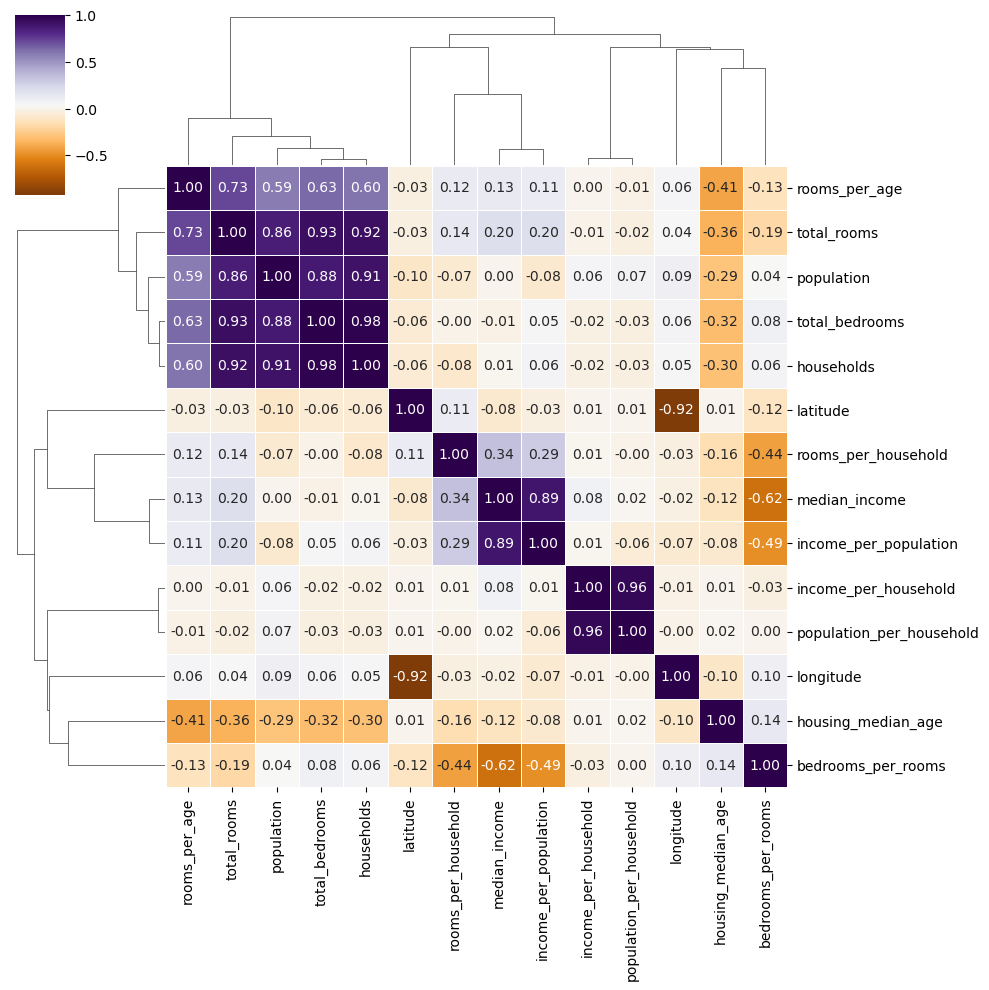

In [19]:
plt.figure(figsize=(10, 8))
sns.clustermap(corr_matrix_new_features.drop(index=['median_house_value'], columns=['median_house_value']), 
               annot=True, fmt='.2f', cmap='PuOr', lw=0.5);

We can see that we have two main clusers of highly correlated features. \
The first one in the upper left corner is mainly related to population in the district, so the more people the more households, the more households the more rooms and the more rooms the more bedrooms. \
The second cluster tells us that income_pre_pop is highly correlated with median_income, but this is not the case for income_per_household, which is correlated only with population_per_household. This is interesting because both those features are only correlated with each other and has almost 0 correlation with other features, it can suggest that those features are highly skewed, or has some bad ouliers. \
housing_median_age is negatively correlated with almost any feature, and the same goes for the ratio of bedrooms per rooms in the household, what is really interesting is that this ratio has high negative correlation with median_income, the ratio tends to be lower but this is because the overall number of rooms tend to goes up with almost constant bedrooms.

Keeping all the highly correlated features can result in multicollinearity, which can result in obtaining an unstable model if we would decide to use linear regression models, as it can cause linear dependency among columns of our data. Intuitively  if we increase population, the number of households will raise since those additional people must have a place to live in, and so the total number of rooms also will raise, so intuitively we have multicollinearity problem. So what we can do about it? There are multiple ways of handling this, we can: 


1. Just drop N-1 highly correlated variables for each "group" we have spotted and keep only the one that has the highest correlation with taget variable. This, of course will result in some lose in information, and can produce so-called omitted-variable bias among the rest of features when proceeding with linear models.
2. We can use PCA among spoted high correlation groups, but there is a publication (Jolliffe, Ian T. (1982). "A note on the Use of Principal Components in Regression") which shows that principal components with low eigenvalues can sometimes be more important than the principal components with high eigenvalues. This means that we can project important features on the subspace with basis for less important features.
3. We can treat the highly correlated group as just a group, because at the group level, multicollinearity is not a problem (Tsao, Min (2022). "Group least squares regression for linear models with strongly correlated predictor variables".). This amounts to finding some new feature that captures the effect of the group. This is done as $X_{new} = X_{old} \mathsf{w}$, where $||\mathsf{w}||_{1} = 1$, so $\mathsf{w}$ is as vector of weights.
4. Leave the model as is, despite multicollinearity. The presence of multicollinearity doesn't affect the efficiency of extrapolating the fitted model to new data, provided that the predictor variables follow the same pattern of multicollinearity in the new data as in the data on which the regression model is based. ( Gujarati, Damodar (2009). "Multicollinearity: what happens if the regressors are correlated?") We would expect that if we gather new data the first group would be still correlated, but we can think of exceptions, for example in some district new houses are build so households is increasing the number of rooms too, but there might be some economical reasons that people are not flowing the region, so we are losing the assumption that the multicollinearity will be the same.

There are few options left like using l2-norm regularization, partial LSR or obtaining more data. We will try to implement all the above options even if we will not use linear model, because one of those methods can still yield better model as three of four methods described above are about reducing the dimentionality.

Now we can check on pairplot how the groups are distributed and what their plots against each other looks like, we may be able to spot what is going on. Since i like hexbin plot this is the one i will use.

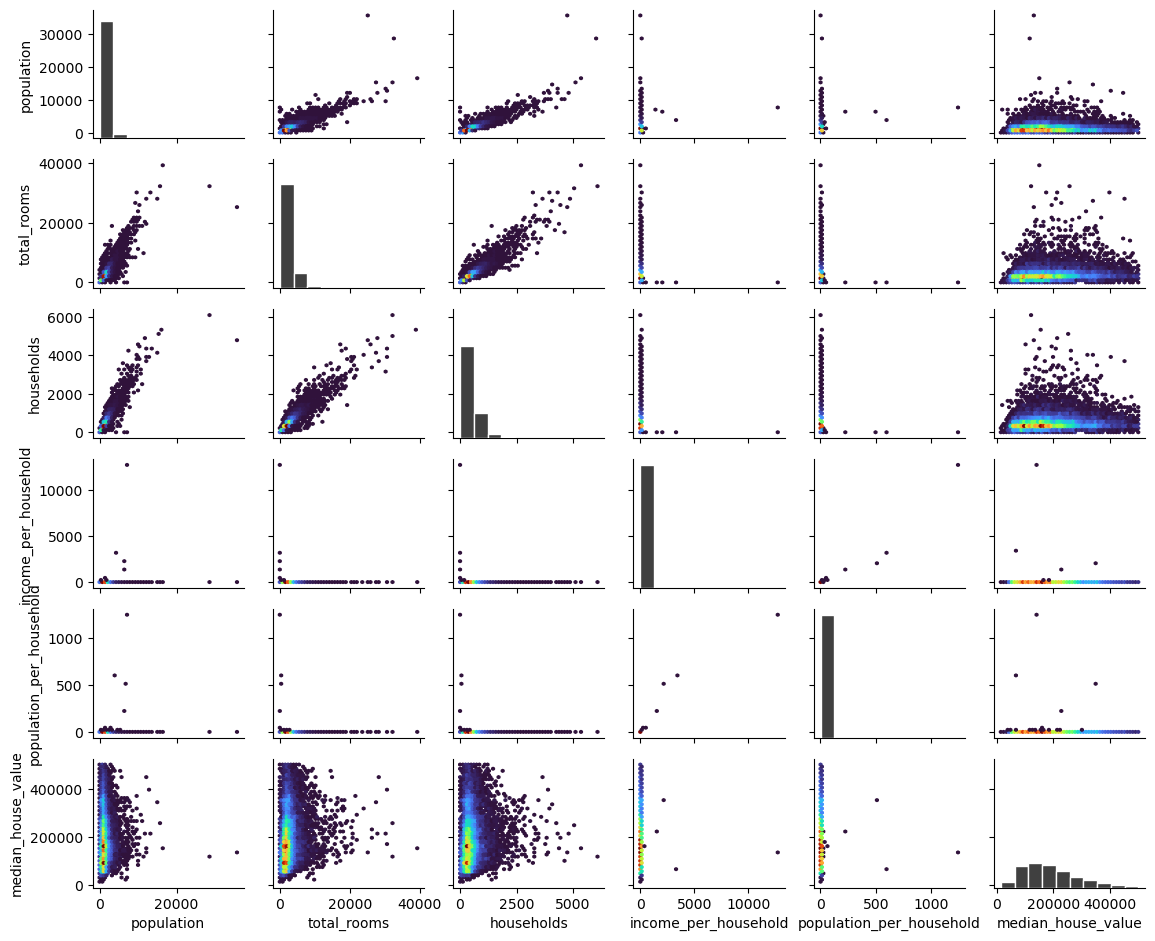

In [20]:
def _hexbin(x, y, color, **kwargs):
    
    # creates hexbin plot
    plt.hexbin(x, y, gridsize=50, cmap=color, mincnt=1, **kwargs)
    
g = sns.PairGrid(tr_num[['population', 'total_rooms', 'households', 'income_per_household', 'population_per_household', 'median_house_value']], 
                 height=1.6, aspect=1.2)
g.map_diag(sns.histplot, color='black', ec='white', bins=10)
g.map_offdiag(_hexbin, color='turbo')

We can see why income_per_household and population_per_household were only correlated with each other and had 0 correlation with other features, they are completely squeezed because of what looks like few outliers. We can identify those points manually.

In [21]:
outlier_check = tr_num.loc[tr_num['population_per_household'].sort_values(ascending=False).index[:14], :].T
outlier_check.style.apply(lambda x: 
                          ['background: #FFAE9B' if (x.name == 'population_per_household' or x.name == 'income_per_household') else '' for i in x],
                          axis=1)

,19006,3364,16669,13034,16420,8874,13366,5986,20352,14756,4479,19435,1039,16672
longitude,-121.980000,-120.510000,-120.700000,-121.150000,-121.290000,-118.450000,-117.630000,-117.710000,-119.090000,-116.970000,-118.160000,-121.040000,-120.970000,-120.690000
latitude,38.320000,40.410000,35.320000,38.690000,37.890000,34.060000,33.940000,34.100000,34.220000,32.560000,34.070000,37.670000,38.420000,35.340000
housing_median_age,45.000000,36.000000,46.000000,52.000000,26.000000,52.000000,36.000000,52.000000,8.000000,23.000000,41.000000,16.000000,16.000000,16.000000
total_rooms,19.000000,36.000000,118.000000,240.000000,161.000000,204.000000,447.000000,567.000000,40.000000,1262.000000,247.000000,19.000000,1748.000000,164.000000
total_bedrooms,5.000000,8.000000,17.000000,44.000000,27.000000,34.000000,95.000000,152.000000,10.000000,294.000000,55.000000,19.000000,322.000000,30.000000
population,7460.000000,4198.000000,6532.000000,6675.000000,1542.000000,1154.000000,2886.000000,2688.000000,309.000000,5176.000000,925.000000,166.000000,4930.000000,542.000000
households,6.000000,7.000000,13.000000,29.000000,30.000000,28.000000,85.000000,126.000000,16.000000,275.000000,50.000000,9.000000,287.000000,32.000000
median_income,10.226400,5.517900,4.263900,6.135900,5.748500,9.337000,4.257800,1.875000,4.020800,2.562500,3.576900,0.536000,4.302900,1.656300
median_house_value,137500.000000,67500.000000,350000.000000,225000.000000,162500.000000,nan,183300.000000,212500.000000,52500.000000,153300.000000,135700.000000,162500.000000,121900.000000,42500.000000
rooms_per_household,3.166667,5.142857,9.076923,8.275862,5.366667,7.285714,5.258824,4.500000,2.500000,4.589091,4.940000,2.111111,6.090592,5.125000


So, what seems to be the problem here? For the first observation of index no. 19006 we can see that the population is 7460, but the region has only 6 households, this seems weird. We can try to argue that it might be the case that those are big hotels classified as households, but quick look at total_rooms reveals 19 rooms, so no matter how much we try to wiggle our explanation it seems like this is just an error. The same goes for the rest of at least few more data points. Of course, it might be the case that some some apartaments or housing complexes vere classified as households, we don't know the exact way of classification, as this information is not provided, but we can check what are percentiles of those features, then we will know how much they are off. 

In [22]:
tr_num[['population_per_household', 'income_per_household']].describe(percentiles=[0.95, 0.99, 0.999, 0.9995]).T

,count,mean,std,min,50%,95%,99%,99.9%,99.95%,max
population_per_household,16512.0,3.096961,11.578744,0.692308,2.817240,4.333333,5.410157,14.783838,19.187131,1243.333333
income_per_household,16512.0,12.504949,104.309177,0.402000,9.983153,22.162385,32.421143,56.939860,126.279331,12714.824000


99.95% of data points have less or equal value than 22.98 in population_per_household, we can tell that the points with value greater than that are more than extreme outliers. There is no reason to keep them, so we should write a function that will drop those samples and be a part of data preprocessing pipeline. If we wouldn't have create that features we would never guess that there are such errors in the data. We can drop the points in two ways, we can either use a fixed value as a reference or use 99.9 percentile (or even lower) as a more flexible reference. We can add those two options to our function. There is also a question based on which feature we should proceed with droping the data? I would argue that we should be dropping based on more skewed feature.

We should also take into consideration that we are going to lose some data, so how much we should be willing to lose? Let's drop all above 99 percentile and see how much data we are dropping.

In [23]:
tr_num.shape[0], tr_num.loc[tr_num['population_per_household'] <= 5.41].shape, tr_num.loc[tr_num['income_per_household'] < 26.82].shape

(16512, (16346, 15), (16127, 15))

So dropping on 99 percentile will get rid of 157 data points, not too much. We can also try to tackle this solution as an optimization problem. Let's calculate skewness of those features and i will explain.

In [24]:
tr_num[['population_per_household', 'income_per_household']].skew()

population_per_household     88.052663
income_per_household        111.964846
dtype: float64

We should be punished for high skewness but also for dropping the data so let's construct simple loss funciton: $S(i) + i$, where $S(i)$ is the skewness after dropping ith point. The more points we get rid of the lower the skewness but ultimatelly we are dropping the data, so we want to find the maximum points we should drop to lower skewness as much as possible with as little points dropped. Also, if skewness ~ 1 the distribution can be treated almost as normal, so this can be another method of dropping those points.

All those ideas can be implemented in a class that will drop those points. We should specify the method of dropping, for example: fixed - with some constant based on percentiles from training set, flexible - dropping on percentiles of actually held data, optimized - based on skewness, or skew - for dropping after $S(i) \approx some\ constant$.

The described task of dropping the outliers is done with the use of DataDropper class imported from, you guessed it, classes_for_pipeline.

In [25]:
# import the class
from classes_for_pipeline_py import DataDropper

# instantiate the class with default penalty of 0.5
features_data_drop = DataDropper(method='optimized')

# fit and transform income_per_household 
features_data_drop.fit(tr_num['income_per_household'])
tr_num.loc[:, 'income_per_household'] = features_data_drop.transform(tr_num['income_per_household'])
print(f'Dropped points: {features_data_drop.number_deleted} for income_per_household')

# fit and transform income_per_household 
features_data_drop.fit(tr_num['population_per_household'])
tr_num.loc[:, 'population_per_household'] = features_data_drop.transform(tr_num['population_per_household'])
print(f'Dropped points: {features_data_drop.number_deleted} for population_per_household')

# print the skewness
tr_num.skew()

Dropped points: 9 for income_per_household
Dropped points: 17 for population_per_household


longitude                   -0.288418
latitude                     0.461504
housing_median_age           0.063453
total_rooms                  4.090691
total_bedrooms               3.415689
population                   5.276131
households                   3.386714
median_income                1.634090
median_house_value           0.807232
rooms_per_household         18.607090
income_per_household         1.893224
income_per_population        1.451086
bedrooms_per_rooms           2.245309
population_per_household     2.690516
rooms_per_age               12.749790
dtype: float64

We were able to reduce skewness of income_per_household from 111 to 1.89 just by dropping 9 data points and population_per_household from 88 to 2.69 by just dropping 17 additional data points using squared root penalty (we can of course try to use different penalties)!

We can also spot that rooms_per_household and rooms_per_age are badly skewed, not as much as two features we have just fixed and showed that the skewness in those features was caused by erroneous data points. We should check if rooms_per_household and rooms_per_age also have some errors in them or the skewness comes from outliers (it might be also the case that those "outliers" are not outliers at all, since we don't have the population distribution).

In [26]:
outlier_check = tr_num.loc[tr_num['rooms_per_household'].sort_values(ascending=False).index[:14], ['total_rooms', 'households', 'housing_median_age', 'rooms_per_household', 'rooms_per_age']].T
outlier_check.style.apply(lambda x: 
                          ['background: #FFAE9B' if (x.name == 'rooms_per_household' or x.name == 'rooms_per_age') else '' for i in x]
                          , axis=1)

,1914,12447,1913,11862,1912,9676,11707,2395,1240,1872,20094,1926,13950,10080
total_rooms,1561.000000,2809.000000,2967.000000,958.000000,1463.000000,5919.000000,2213.000000,1881.000000,1568.000000,1709.000000,7005.000000,1961.000000,4773.000000,4195.000000
households,11.000000,45.000000,48.000000,16.000000,26.000000,112.000000,42.000000,37.000000,33.000000,44.000000,189.000000,53.000000,130.000000,115.000000
housing_median_age,33.000000,17.000000,19.000000,25.000000,16.000000,14.000000,22.000000,23.000000,11.000000,27.000000,26.000000,11.000000,21.000000,8.000000
rooms_per_household,141.909091,62.422222,61.812500,59.875000,56.269231,52.848214,52.690476,50.837838,47.515152,38.840909,37.063492,37.000000,36.715385,36.478261
rooms_per_age,47.303030,165.235294,156.157895,38.320000,91.437500,422.785714,100.590909,81.782609,142.545455,63.296296,269.423077,178.272727,227.285714,524.375000


So, taking a quick peek at index no. 1914 we can see that there are a lot of rooms (~1.5k) for just 11 houses. Seems like a lot to me. I have just checked "top biggest houses in the world", the first one have 1700 rooms, but the third one has 250 rooms, and the rest have less, but those houses are scattered all around the world. Other thing to notice is that we don't know how the data was collected and what was considered a household. We can imagine a region filled with hotels or big housing complexes, and if they were classified as a one household, then it would be the case that one household would have a lot of rooms. Let's check percentiles to be double sure that those values are rare if they drop quickly.

In [27]:
tr_num[['rooms_per_household', 'rooms_per_age']].describe(percentiles=[0.95, 0.99, 0.999, 0.9995]).T

,count,mean,std,min,50%,95%,99%,99.9%,99.95%,max
rooms_per_household,16512.0,5.435235,2.387375,0.888889,5.235874,7.645946,10.318432,31.412271,45.298883,141.909091
rooms_per_age,16512.0,164.495373,395.223164,0.153846,74.397368,516.850000,1680.314000,4720.356500,6164.329333,15225.000000


The values are not as bad as they were before, but still we can see that the values between 99.95% and max are higher than the differences between other percentiles. Using the DataDropper we will drop some more points.

In [28]:
# instantiate the class with default penalty of 0.5
features_per_household_data_drop = DataDropper(method='optimized', penalty=0.25)

# fit and transform rooms_per_household 
features_per_household_data_drop.fit(tr_num['rooms_per_household'])
tr_num.loc[:, 'rooms_per_household'] = features_per_household_data_drop.transform(tr_num['rooms_per_household'])
print(f'Dropped points: {features_per_household_data_drop.number_deleted} for rooms_per_household')

# fit and transform rooms_per_age 
features_per_household_data_drop.fit(tr_num['rooms_per_age'])
tr_num.loc[:, 'rooms_per_age'] = features_per_household_data_drop.transform(tr_num['rooms_per_age'])
print(f'Dropped points: {features_per_household_data_drop.number_deleted} for rooms_per_age')

# print the skewness
tr_num.skew()

Dropped points: 18 for rooms_per_household
Dropped points: 12 for rooms_per_age


longitude                  -0.288418
latitude                    0.461504
housing_median_age          0.063453
total_rooms                 4.090691
total_bedrooms              3.415689
population                  5.276131
households                  3.386714
median_income               1.634090
median_house_value          0.807232
rooms_per_household         4.535355
income_per_household        1.893224
income_per_population       1.451086
bedrooms_per_rooms          2.245309
population_per_household    2.690516
rooms_per_age               7.401946
dtype: float64

Great! rooms_per_age are still highly skewed, but we will leave it like that for now. Let's check how the histograms have changed.

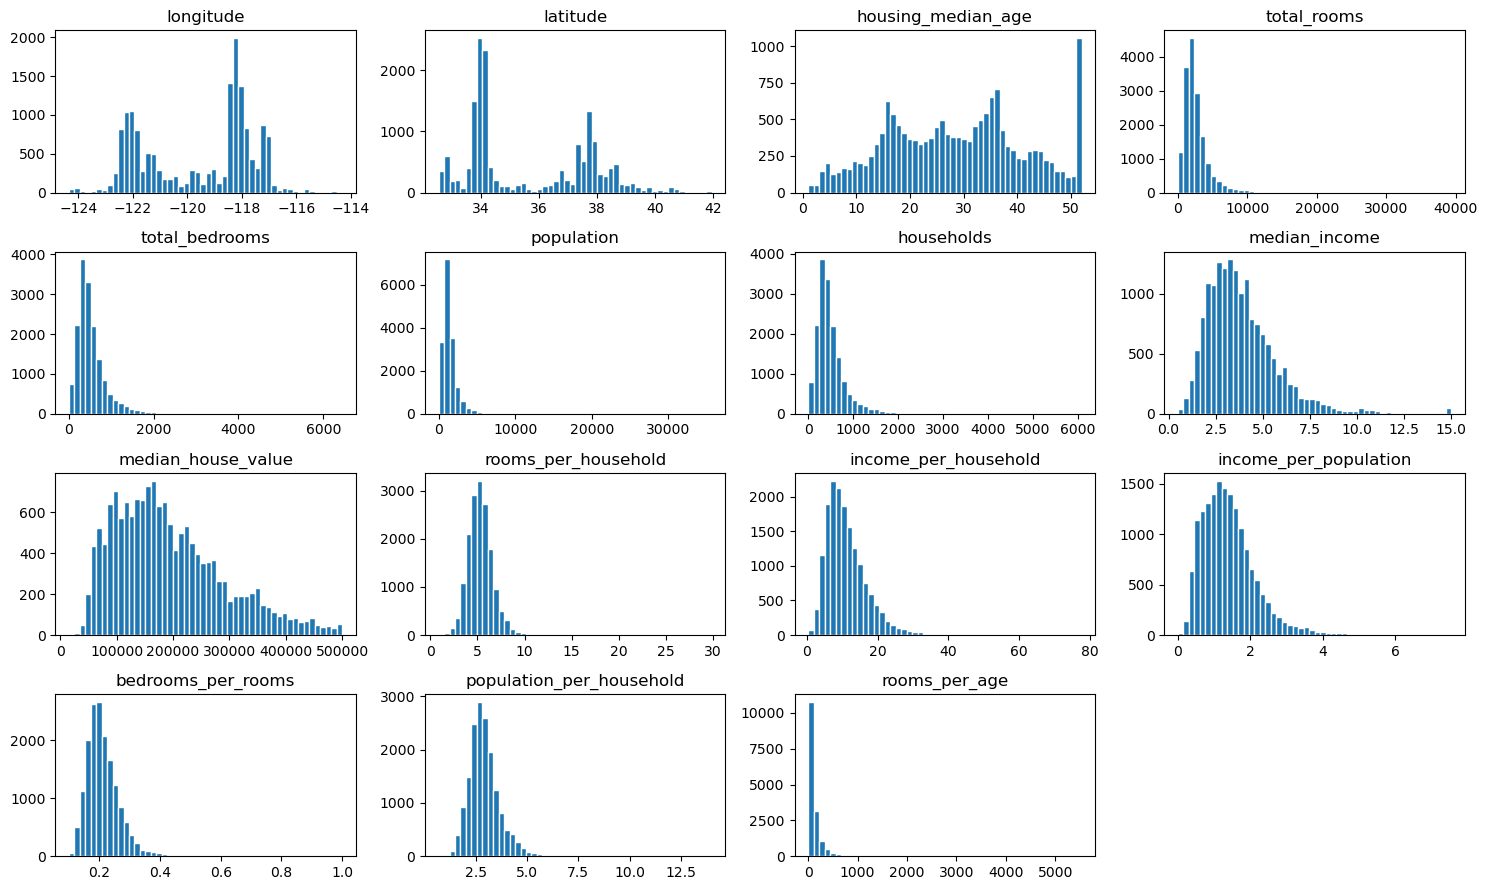

In [29]:
# plot the histograms
tr_num.hist(ec='white', bins=50, figsize=(15, 9), grid=False)
plt.tight_layout();

This looks really nice, we can clearly see that some distributions are still highly skewed like rooms_per_age, but we will leave it like that and use some power transformation to unskew those point more instead of dropping them. But if that does not help we will return to the DataDropper class and use different penalty or different method.

We can check the correlation between features and target variable to see how our method implemented above changed the linear correlations.

In [30]:
corr_matrix_outliers_dropped = tr_num.corr()
corr_matrix_outliers_dropped['median_house_value'].sort_values(ascending=False)\
    .to_frame().join(corr_matrix_new_features['median_house_value'].sort_values(ascending=False), rsuffix='_old')

,median_house_value,median_house_value_old
median_house_value,1.000000,1.000000
income_per_population,0.691254,0.691254
median_income,0.642407,0.642407
income_per_household,0.422128,0.016826
rooms_per_household,0.159413,0.116741
total_rooms,0.144983,0.144983
households,0.096007,0.096007
total_bedrooms,0.076054,0.076054
housing_median_age,0.061479,0.061479
rooms_per_age,0.060960,0.049959


We can see big jump in correlations of population_per_household and income_per_household, also rooms_per_household gained 0.04 in correlation. Now let's take a look at the correlation between features.

<Figure size 1000x800 with 0 Axes>

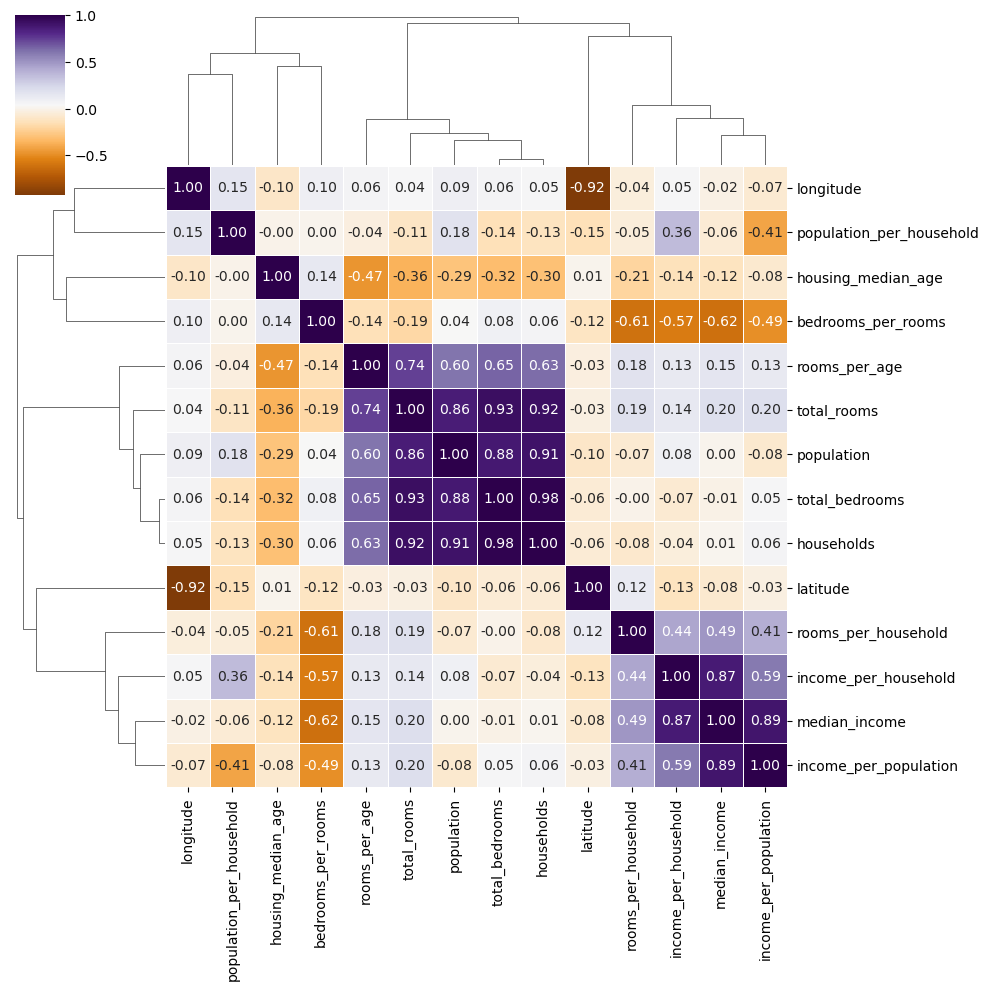

In [31]:
plt.figure(figsize=(10, 8))
sns.clustermap(corr_matrix_outliers_dropped.drop(index=['median_house_value'], columns=['median_house_value']), 
               annot=True, fmt='.2f', cmap='PuOr', lw=0.5);

Now, we have to deal with multicollinearity that is present among our variables. We can clearly see two groups in above heatmap. The first one is [total_rooms, population, total_bedrooms, households] and the second one is [income_per_household, median_income, income_per_population]. Below i will paste the options i have described at the beginning.
***
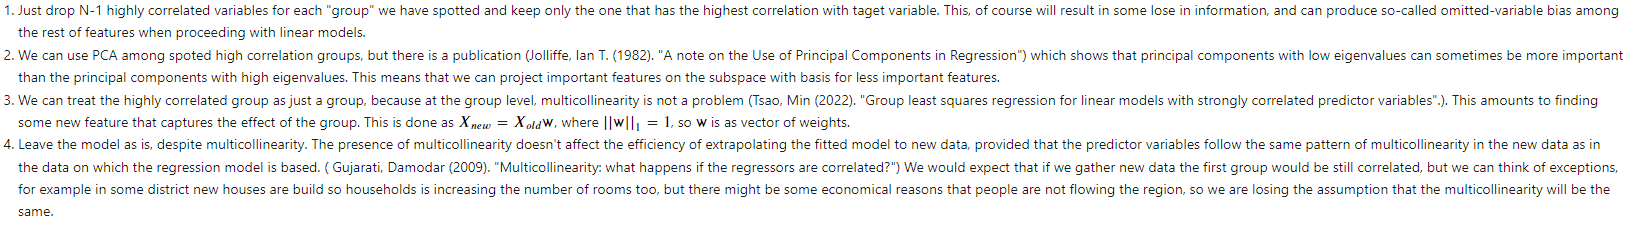
***
There is another option that i came up with. Since correlated features points in the same direction in the feature space we can imagine that there exist an affine space, and we would like to find an affine combinantion of our highly correlated vectors to create a new one. I will add such option to a MulticollinearityHandler class, but this is just my idea. Since this new feature is an affine combination we can think of some interpretation of it, as a weighted feature.

As of now we will not change our vectors in any way to try to battle the multicollinearity, as in my opinion we are dealing with 4th point, where the multicollinearity in my opinion is somewhat natural occurence among those features. We should expect total_rooms, total_bedrooms, and households to tend to go up as population goes up. Similar argument can be stated for the second group of features.

***
Let's create a pipeline to this point, that will take all our data from tr_num and create the final cut. Let it be a simple function, we can change it to class later down the road.

In [69]:
# import small_Pipeline
from classes_for_pipeline_py import small_Pipeline

def fast_pipeline(X):
    
    # simple imputer with median strategy
    imputer_columns = np.setdiff1d(X.columns, 'ocean_proximity').tolist()
    imputer_pipeline = small_Pipeline([(SimpleImputer(strategy='median'), imputer_columns)])
    X = imputer_pipeline.fit_transform(X)
    
    # add features
    X = FeaturesAdder().fit_transform(X)
    
    # dropping outliers pipeline
    sp = small_Pipeline([
        (CappedTargetDropper(capped_val=X['median_house_value'].max()), 'median_house_value'),
        (DataDropper(method='optimized'), 'income_per_household'),
        (DataDropper(method='optimized'), 'population_per_household'),
        (DataDropper(method='optimized', penalty=0.25), 'rooms_per_household'),
        (DataDropper(method='optimized', penalty=0.25), 'rooms_per_age')
    ])
    
    X = sp.fit_transform(X)
    X = X.dropna()
    
    return X

With this simple function we can control the data as it goes to the modeling step.

***
So, now let's focus our attention on the only categrical feature "ocean_proximity". First we should check how many distinct values are among this feature, and what they are. We should then check how is our target variable distributed among different values. We can do hypotheses tests to determine if there is a significant difference between values. 

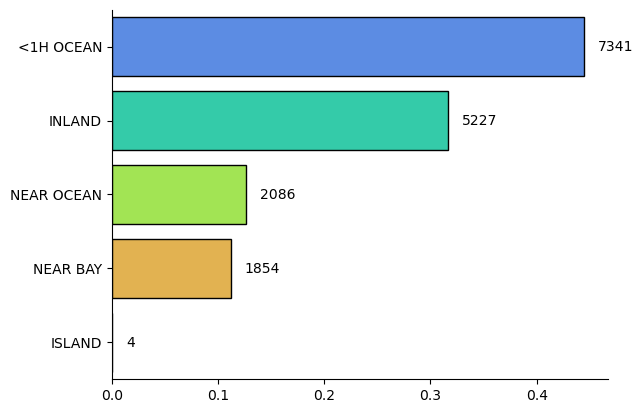

In [33]:
# add target variable to the tr_cat
tr_cat = tr_cat.to_frame()
tr_cat.loc[:, 'median_house_value'] = tr_num['median_house_value']

# print the distinct values and their relative frequency
g = sns.barplot(x=tr_cat['ocean_proximity'].value_counts(normalize=True).values,
                y=tr_cat['ocean_proximity'].value_counts(normalize=True).index,
                palette='turbo', ec='black')
g.bar_label(g.containers[0], labels=tr_cat['ocean_proximity'].value_counts().values.round(), padding=10)
g.spines[['right', 'top']].set_visible(False)
plt.show()

From above graph we can see that we have five distinct categories, that represents different placements of households. We could imagine them on the map as contour lines. As expected in California most houses are either INLAND or close to the ocean (NEAR OCEAN + <1H OCEAN). There is also an island category, but we can see that there is almost no island! Only 4 observations contain island at all. If we let island be a bernoullie random variable, then we can see that $Var(island) \approx 0.0002$. This means that there is almost no variance if we were to create a dummy variable, meaning that those observations does not make any difference in training the model. We should drop them and not even bother.

In [34]:
# drop the island
tr_cat.loc[tr_cat['ocean_proximity'] == 'ISLAND', 'ocean_proximity'] = np.nan

What should we do with the rest of categories? They seem to be ordinal categorical variables, but denoting them with LabelEndocer will result in equidistant categories, but near ocean and inland are not equidistant. The concept of distance in those categories is ambiguous. For this reason we should create a dummy variables. But first, let's take a look at how our target is dependent on those categories. We will use a box plot and plot horizontally kde plots to be able to say something more about the distributions.

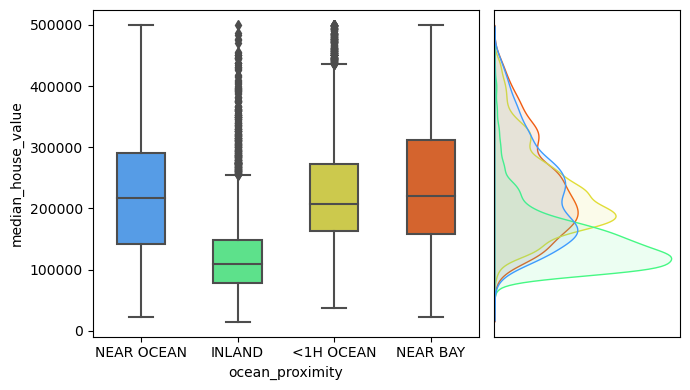

In [35]:
plt.figure(figsize=(7, 4))
plt.subplot(1, 3, (1, 2))
sns.boxplot(x='ocean_proximity', y='median_house_value', data=tr_cat,
            width=0.5, palette='turbo')
plt.subplot(1, 3, 3)
g = sns.kdeplot(y='median_house_value', data=tr_cat, hue='ocean_proximity', 
                palette='turbo', legend=False, 
                bw_adjust=1, common_norm=False, 
                alpha=0.1, fill=True)
g.set(xlabel=(''), ylabel=(''), xticks=([]), yticks=([]))
plt.tight_layout()
plt.show()

At first sight, we can tell INLAND from the other categories, but there is no simple way of telling the others apart, they have similar mean values, similar IQR and even range across the whole target variable. Beside this what can be said about them picking one by one? 
* There are a lot of 1.5\*IQR outliers in the INLAND category, which is something we should expect. There are a lot of "normal" houses and then there are some more exclusive, there are a lot less of them and they cost more. Thus, the gamma shaped distribution.
* The distribution of <1H OCEAN looks like translated version of INLAND category, it has more variance and a bump going up in median house price. We should expect similar distribution as INLAND but the houses on average should, and are, more expensive because of the proximity to the ocean.
* NEAR BAY and NEAR OCEAN are distributed similary, they seem to have similar mode as <1H OCEAN. They are almost normal, but with more heavy right tail (skew < 0.55).

We will test if the differences between "NEAR OCEAN", "NEAR BAY", "<1H OCEAN", and "INLAND" are significant, by checking statistical power for effect size determined by Cohen d value. We are going to sample 500 values from the data and check the power. We will now create simple functions that will help us calculate power.

***

In [36]:
def cohen(X, cols=[], dv='median_house_value'):
    group = X.groupby('ocean_proximity')[dv].agg(['var', 'count', 'mean'])
    col_1, col_2 = cols
    nom = (group.loc[col_1, 'count'] - 1) * group.loc[col_1, 'var'] + (group.loc[col_2, 'count'] - 1) * group.loc[col_2, 'var']
    denom = group.loc[col_1, 'count'] + group.loc[col_2, 'count'] - 2 
    pooled = np.sqrt(nom / denom)
    return (group.loc[col_1, 'mean'] - group.loc[col_2, 'mean']) / pooled 

def count(X, cols=[]):
    group = X.groupby('ocean_proximity')['median_house_value'].agg(['var', 'count', 'mean'])
    col_1, col_2 = cols
    return group.loc[col_1, 'count'], group.loc[col_2, 'count']

Now we sample the data using stratified split.

In [37]:
_, strat_sample = train_test_split(tr_cat.dropna(), test_size=0.0175, stratify=tr_cat.dropna()['ocean_proximity'], random_state=42)

We can now calculate the power using pg.power_ttest2n().

In [38]:
for col in strat_sample['ocean_proximity'].unique():
    if col != 'INLAND':
        d = cohen(strat_sample, [col, "INLAND"])
        print(f'Col:{col}, d-val: {d.round(2)}, power: {pg.power_ttest2n(*count(strat_sample, [col, "INLAND"]), d=d)}')

Col:<1H OCEAN, d-val: 1.3, power: 0.9999999999999122
Col:NEAR OCEAN, d-val: 1.64, power: 0.9999999995773282
Col:NEAR BAY, d-val: 1.91, power: 0.9999999999990721


We have more than enough power to test if the observed difference between "INLAND" and rest groups is significant. First we should thest normality and homoscedasticity to be sure that ttest is valid.

In [39]:
pg.normality(data=strat_sample, dv='median_house_value', group='ocean_proximity')

,W,pval,normal
INLAND,0.884856,8.061112e-07,False
<1H OCEAN,0.926965,5.766369e-06,False
NEAR OCEAN,0.952522,1.461009e-01,True
NEAR BAY,0.961633,3.407971e-01,True


In [40]:
pg.homoscedasticity(data=strat_sample, dv='median_house_value', group='ocean_proximity')

,W,pval,equal_var
levene,8.294862,0.000027,False


The problem might be that with 500 samples we can flag small departures from the normality and homoscedasticity as not significant. We can transform the target variable to be more normal shaped in turn causing groups to be more normal-like. We can also check qq plots for visual diagnosis and calculate correlations of the rests for any group assuming mean model.

In [41]:
tr_cat.loc[:, 'm_p'] = PowerTransformer().fit_transform(tr_cat['median_house_value'].values.reshape(-1, 1))
_, strat_sample = train_test_split(tr_cat.dropna(), test_size=0.0175, stratify=tr_cat.dropna()['ocean_proximity'], random_state=42)

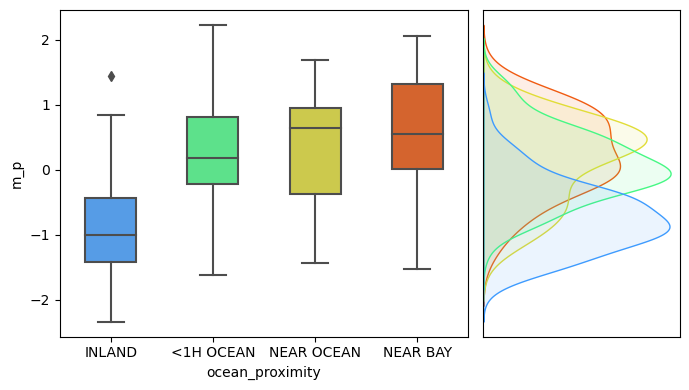

In [42]:
plt.figure(figsize=(7, 4))
plt.subplot(1, 3, (1, 2))
sns.boxplot(x='ocean_proximity', y='m_p', data=strat_sample,
            width=0.5, palette='turbo')
plt.subplot(1, 3, 3)
g = sns.kdeplot(y='m_p', data=strat_sample, hue='ocean_proximity', 
                palette='turbo', legend=False, 
                bw_adjust=1, common_norm=False, 
                alpha=0.1, fill=True)
g.set(xlabel=(''), ylabel=(''), xticks=([]), yticks=([]))
plt.tight_layout()
plt.show()

In [43]:
pg.normality(data=strat_sample, dv='m_p', group='ocean_proximity')

,W,pval,normal
INLAND,0.979913,0.172746,True
<1H OCEAN,0.988299,0.389129,True
NEAR OCEAN,0.929166,0.029583,False
NEAR BAY,0.969744,0.532197,True


In [44]:
pg.homoscedasticity(data=strat_sample, dv='m_p', group='ocean_proximity')

,W,pval,equal_var
levene,1.168105,0.322281,True


In [45]:
k = strat_sample.groupby('ocean_proximity')['m_p'].agg(['mean', 'std', 'count'])
k.loc[:, 'se'] = k['std'] / np.sqrt(k['count'])
k

,mean,std,count,se
ocean_proximity,,,,
<1H OCEAN,0.264200,0.797681,121,0.072516
INLAND,-0.906301,0.763797,91,0.080068
NEAR BAY,0.546370,0.906063,30,0.165424
NEAR OCEAN,0.337328,0.916747,34,0.157221


In [46]:
pg.pairwise_tests(data=strat_sample, dv='m_p', between='ocean_proximity').round(3)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,ocean_proximity,<1H OCEAN,INLAND,False,True,10.835,198.191,two-sided,0.000,6.431e+18,1.489
1,ocean_proximity,<1H OCEAN,NEAR BAY,False,True,-1.562,40.852,two-sided,0.126,0.629,-0.342
2,ocean_proximity,<1H OCEAN,NEAR OCEAN,False,True,-0.422,47.938,two-sided,0.675,0.222,-0.088
3,ocean_proximity,INLAND,NEAR BAY,False,True,-7.904,43.412,two-sided,0.000,3.746e+09,-1.803
4,ocean_proximity,INLAND,NEAR OCEAN,False,True,-7.049,51.077,two-sided,0.000,6.431e+07,-1.530
5,ocean_proximity,NEAR BAY,NEAR OCEAN,False,True,0.916,61.183,two-sided,0.363,0.365,0.226


In [47]:
pg.pairwise_tukey(data=strat_sample, dv='m_p', between='ocean_proximity').round(3)

C:\Users\a2d2\AppData\Roaming\Python\Python38\site-packages\pingouin\parametric.py:992: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  sserror = grp.apply(lambda x: (x - x.mean()) ** 2).sum()


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,<1H OCEAN,INLAND,0.264,-0.906,1.171,0.113,10.358,0.000,1.432
1,<1H OCEAN,NEAR BAY,0.264,0.546,-0.282,0.166,-1.699,0.326,-0.345
2,<1H OCEAN,NEAR OCEAN,0.264,0.337,-0.073,0.158,-0.463,0.967,-0.089
3,INLAND,NEAR BAY,-0.906,0.546,-1.453,0.171,-8.473,0.000,-1.772
4,INLAND,NEAR OCEAN,-0.906,0.337,-1.244,0.164,-7.597,0.000,-1.518
5,NEAR BAY,NEAR OCEAN,0.546,0.337,0.209,0.204,1.025,0.735,0.254


***

We have to power transform and standardize the numerical features, it will lower the skewness of features and standardizing them will help with the scale. Those methods should help the optimizer to find right solution vector. We have to keep the lambda values and all the mean and std values, because we will be using them on the test set. For this reason we should make a class that will keep all those values in it. We will be also creatin dummy variables from categorical data, thus we will already put this method in the class.

In [68]:
tr_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,income_per_household,income_per_population,bedrooms_per_rooms,population_per_household,rooms_per_age
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,5.017657,12.033836,0.882926,0.200576,3.691814,94.727273
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,4.473545,6.626488,2.193493,0.232703,1.738095,69.020408
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,5.645833,11.318496,1.526248,0.174486,2.723214,474.250000
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,4.002817,7.759056,0.486310,0.258269,3.994366,39.472222
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,6.268421,8.174660,1.545304,0.180940,2.300000,55.395349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,-117.96,33.78,35.0,1330.0,201.0,658.0,217.0,6.3700,229200.0,6.129032,19.315484,2.100745,0.151128,3.032258,38.000000
11964,-117.43,34.02,33.0,3084.0,570.0,1753.0,449.0,3.0500,97800.0,6.868597,11.907906,0.781204,0.184825,3.904232,93.454545
5390,-118.38,34.03,36.0,2101.0,569.0,1756.0,527.0,2.9344,222100.0,3.986717,9.777621,0.880654,0.270823,3.332068,58.361111
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,6.395349,18.180713,1.799118,0.166993,3.178891,238.333333


In [66]:
tr_num.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'rooms_per_household', 'income_per_household',
       'income_per_population', 'bedrooms_per_rooms',
       'population_per_household', 'rooms_per_age'],
      dtype='object')

In [ ]:
PowerTransformer()

In [238]:
class PreprocessPipeline(BaseEstimator, TransformerMixin):
    
    '''any transformer can be access via 
    PreprocessPipeline.name_of_transformer.list_of_transformers[0][0].statistic_in_question'''
    
    def __init__(self):
        self.median_imputer = small_Pipeline([
            (SimpleImputer(strategy='median'), 
             ['longitude', 'latitude', 'housing_median_age',
              'total_rooms', 'total_bedrooms', 'population', 
              'households', 'median_income', 'median_house_value'])
        ])
        self.feature_adder = FeaturesAdder()
        self.outliers_dropper = small_Pipeline([
            (CappedTargetDropper(capped_val=500000.0), 'median_house_value'),
            (DataDropper(method='optimized'), 'income_per_household'),
            (DataDropper(method='optimized'), 'population_per_household'),
            (DataDropper(method='optimized', penalty=0.25), 'rooms_per_household'),
            (DataDropper(method='optimized', penalty=0.25), 'rooms_per_age')
        ])
        self.standardizer = small_Pipeline([
            (StandardScaler(), 
             ['longitude', 'latitude'])
        ])
        self.power_transformer = small_Pipeline([
            (PowerTransformer(),
             ['housing_median_age', 'total_rooms',
              'total_bedrooms', 'population', 'households', 'median_income',
              'median_house_value', 'rooms_per_household', 'income_per_household',
              'income_per_population', 'bedrooms_per_rooms',
              'population_per_household', 'rooms_per_age'])
        ])
        
    def fit(self, X):
        
        self.median_imputer.fit(X)
        
        # since all the later methods are obtained with nans imputed and added
        # new features we have to transform X and add new features,
        # then fit the other classes
        X = self.median_imputer.transform(X)
        X = self.feature_adder.fit_transform(X)
        
        self.outliers_dropper.fit(X)
        self.standardizer.fit(X)
        self.power_transformer.fit(X)
        
        return self
    
    def transform(self, X):
        
        X = self.median_imputer.transform(X)
        X = self.feature_adder.fit_transform(X)
        X = self.outliers_dropper.transform(X)
        X = X.dropna()
        X = self.standardizer.transform(X)
        X = self.power_transformer.transform(X)
        
        X_cat = X['ocean_proximity'].copy()
        X_num = X.drop(columns=['ocean_proximity'])
        
        X_cat.loc[X_cat == 'ISLAND'] = np.nan
        X_merged = pd.merge(X_num, pd.get_dummies(X_cat, drop_first=True), left_index=True, right_index=True)
        
        return X_merged        

In [239]:
tt = train.copy()

In [240]:
PP = PreprocessPipeline()

In [241]:
PP.fit(tt)

PreprocessPipeline()

In [242]:
PP.standardizer.list_of_transformers[0][0].var_

array([4.02240251, 4.5650621 ])

In [243]:
PP.transform(tt).skew()

latitude                    0.463533
longitude                  -0.290290
housing_median_age         -0.112063
total_rooms                 0.096916
total_bedrooms              0.092429
population                  0.094677
households                  0.110876
median_income              -0.000224
median_house_value         -0.025783
rooms_per_household        -0.353469
income_per_household       -0.245432
income_per_population       0.025197
bedrooms_per_rooms          0.012390
population_per_household   -0.243499
rooms_per_age              -0.044465
INLAND                      0.792937
NEAR BAY                    2.457360
NEAR OCEAN                  2.251385
dtype: float64